In [4]:
import json
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib import pyplot as plt
import os
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# Importing sklearn and TSNE.
import sklearn
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
#from sklearn.utils.extmath import _ravel

import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer as tf_idf_transform
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

In [ ]:
# Path to general CORD-19 Data on my local machine
path = '/Users/Sam/Desktop/School/COVID-19 Data'
# Path to biorxiv/medrxiv articles
biomed = path + '/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json'
# Path to comm use PMC articles
pmc = path + '/comm_use_subset/comm_use_subset/pmc_json'

In [ ]:
def get_authors(paper):
    """
    Return authors dict and list of strings representing author names in
    more readable format.
    """

    authors = paper['metadata']['authors']
    author_strs = [
    author['first'] + ' ' + ' '.join(author['middle'])
    + ('' if author['middle'] == [] else ' ') + author['last']
    for author in authors]
    return (authors, author_strs)


def articles_from_dirs(dirs, epoch_size):
    """
    Returns number of articles and list of article info for each article
    in a CORD-19 subdir containing json files.

    Article info returned in format
    {'id':<str>  # 40-char SHA1 of pdf provided by CORD-19 dataset
     'title': <str>  # article title, all lowercase
     'authors': <list of str>  # list of author names in readable format
     'text': <str>    # string of full article text}

    dir : list of string
        paths to directories containing CORD-19 json files.
    """

    # Total article count
    article_count = 0
    articles = []

    for dir in dirs:
        print("Reading files from directory: " + dir)
        for file in os.listdir(dir):
            if file.endswith('.json'):
                # Read file text
                fullpath = dir + '/' + file
                text = open(fullpath, 'r').read()
                # Parse as JSON object
                paper = json.loads(text)

                # Extract paper id
                id = paper['paper_id']

                # Extract paper title, make lowercase for normalization purposes
                title = paper['metadata']['title'].lower()

                # Extract author data (list of dicts contain first, last, etc.)
                (_, author_strs) = get_authors(paper)

                # Extract all text from abstract
                abstr = ''
                if 'abstract' in paper:
                    abstr = ' '.join([par['text'] for par in paper['abstract']])
                # Extract all paragraphs from body
                body = ' '.join([par['text'] for par in paper['body_text']])
                fulltext = abstr + ' ' + body

                info = {}
                info['id'] = id
                info['title'] = title
                info['authors'] = author_strs
                info['text'] = fulltext
                articles.append(info)

                article_count += 1
                if epoch_size > 0:
                    if article_count == epoch_size:
                        return article_count, articles

    return article_count, articles

In [6]:
# An user defined function to create scatter plot of vectors
# Adapted from an article describing how to plot image and word vectors (linked below)
# https://towardsdatascience.com/plotting-text-and-image-vectors-using-t-sne-d0e43e55d89
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 18))

    # We create a scatter plot.
    f = plt.figure(figsize=(32, 32))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120,
                    c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each cluster.
    txts = []
    for i in range(18):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=50)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [7]:
# Uses a k-means clustering technique, adapted from scikitlearn's "Clustering text documents using k-means" linked below
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
def cluster(normalized, clusters):
    km = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1)
    km.fit(normalized)
    labeled_results=km.labels_ 

    article_clusters = pd.DataFrame(labeled_results.tolist())
    
    print(article_clusters)
    return labeled_results

In [8]:
# This is linear dimensionality reduction, again adapted from scikitlearn linked below
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py
# Explanation of TruncatedSVD linked below
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD
def lsa_reduction(result):
    svd = TruncatedSVD(n_components=100)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    
    result = lsa.fit_transform(result)
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    
    return result

In [9]:
#vectorizing using TF-IDF
def vectorize(count, articles):
     # Extract all text from each article
    texts = [article['text'] for article in articles]

    # Run TF-IDF on all article texts
    print("Performing TF-IDF on " + str(count) + " CORD-19 articles.")
    tf_idf_vec = tf_idf(input='content',
                        strip_accents='unicode')
    result = tf_idf_vec.fit_transform(texts)
    
    # Store each document vector in list of article info
    for i in range(count):
        articles[i]['vec'] = result.getrow(i).toarray()
        '''print(articles[i]['title'])
        print(articles[i]['authors'])
        print(articles[i]['vec'])'''
    return result

In [14]:
def main():
    """
    Create sparse feature vectors for all biorxiv/medrxiv and pmc articles
    in CORD-19 dataset using TF-IDF.
    """
    epoch_size = 1000;
    num_clusters = 5;
    # Random state for TSNE.
    RS = 25111993
    
    count, articles = articles_from_dirs([biomed], epoch_size)
    tf_idf_vectors = vectorize(count, articles)
    normalized = lsa_reduction(tf_idf_vectors)
    labeled_results = cluster(normalized, num_clusters)
    digits_proj = TSNE(random_state=RS).fit_transform(normalized)
    print(list(range(0,18)))
    sns.palplot(np.array(sns.color_palette("hls", num_clusters)))
    scatter(digits_proj, labeled_results)
    
    print(articles[0]);

Reading files from directory: /Users/Sam/Desktop/School/COVID-19 Data/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json
Performing TF-IDF on 1000 CORD-19 articles.
Explained variance of the SVD step: 36%
     0
0    1
1    2
2    2
3    2
4    2
..  ..
995  3
996  3
997  1
998  3
999  1

[1000 rows x 1 columns]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
{'id': '0015023cc06b5362d332b3baf348d11567ca2fbb', 'title': 'the rna pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3', 'authors': ['Joseph C Ward', 'Lidia Lasecka-Dykes', 'Chris Neil', 'Oluwapelumi Adeyemi', 'Sarah ', ' Gold', 'Niall Mclean', 'Caroline Wright', 'Morgan R Herod', 'David Kealy', 'Emma ', 'Warner ', 'Donald P King', 'Tobias J Tuthill', 'David J Rowlands', 'Nicola J ', 'Stonehouse A#'], 'text': 'word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstr

c:\users\sam\python\python 38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sam\python\python 38\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


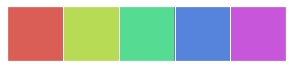

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


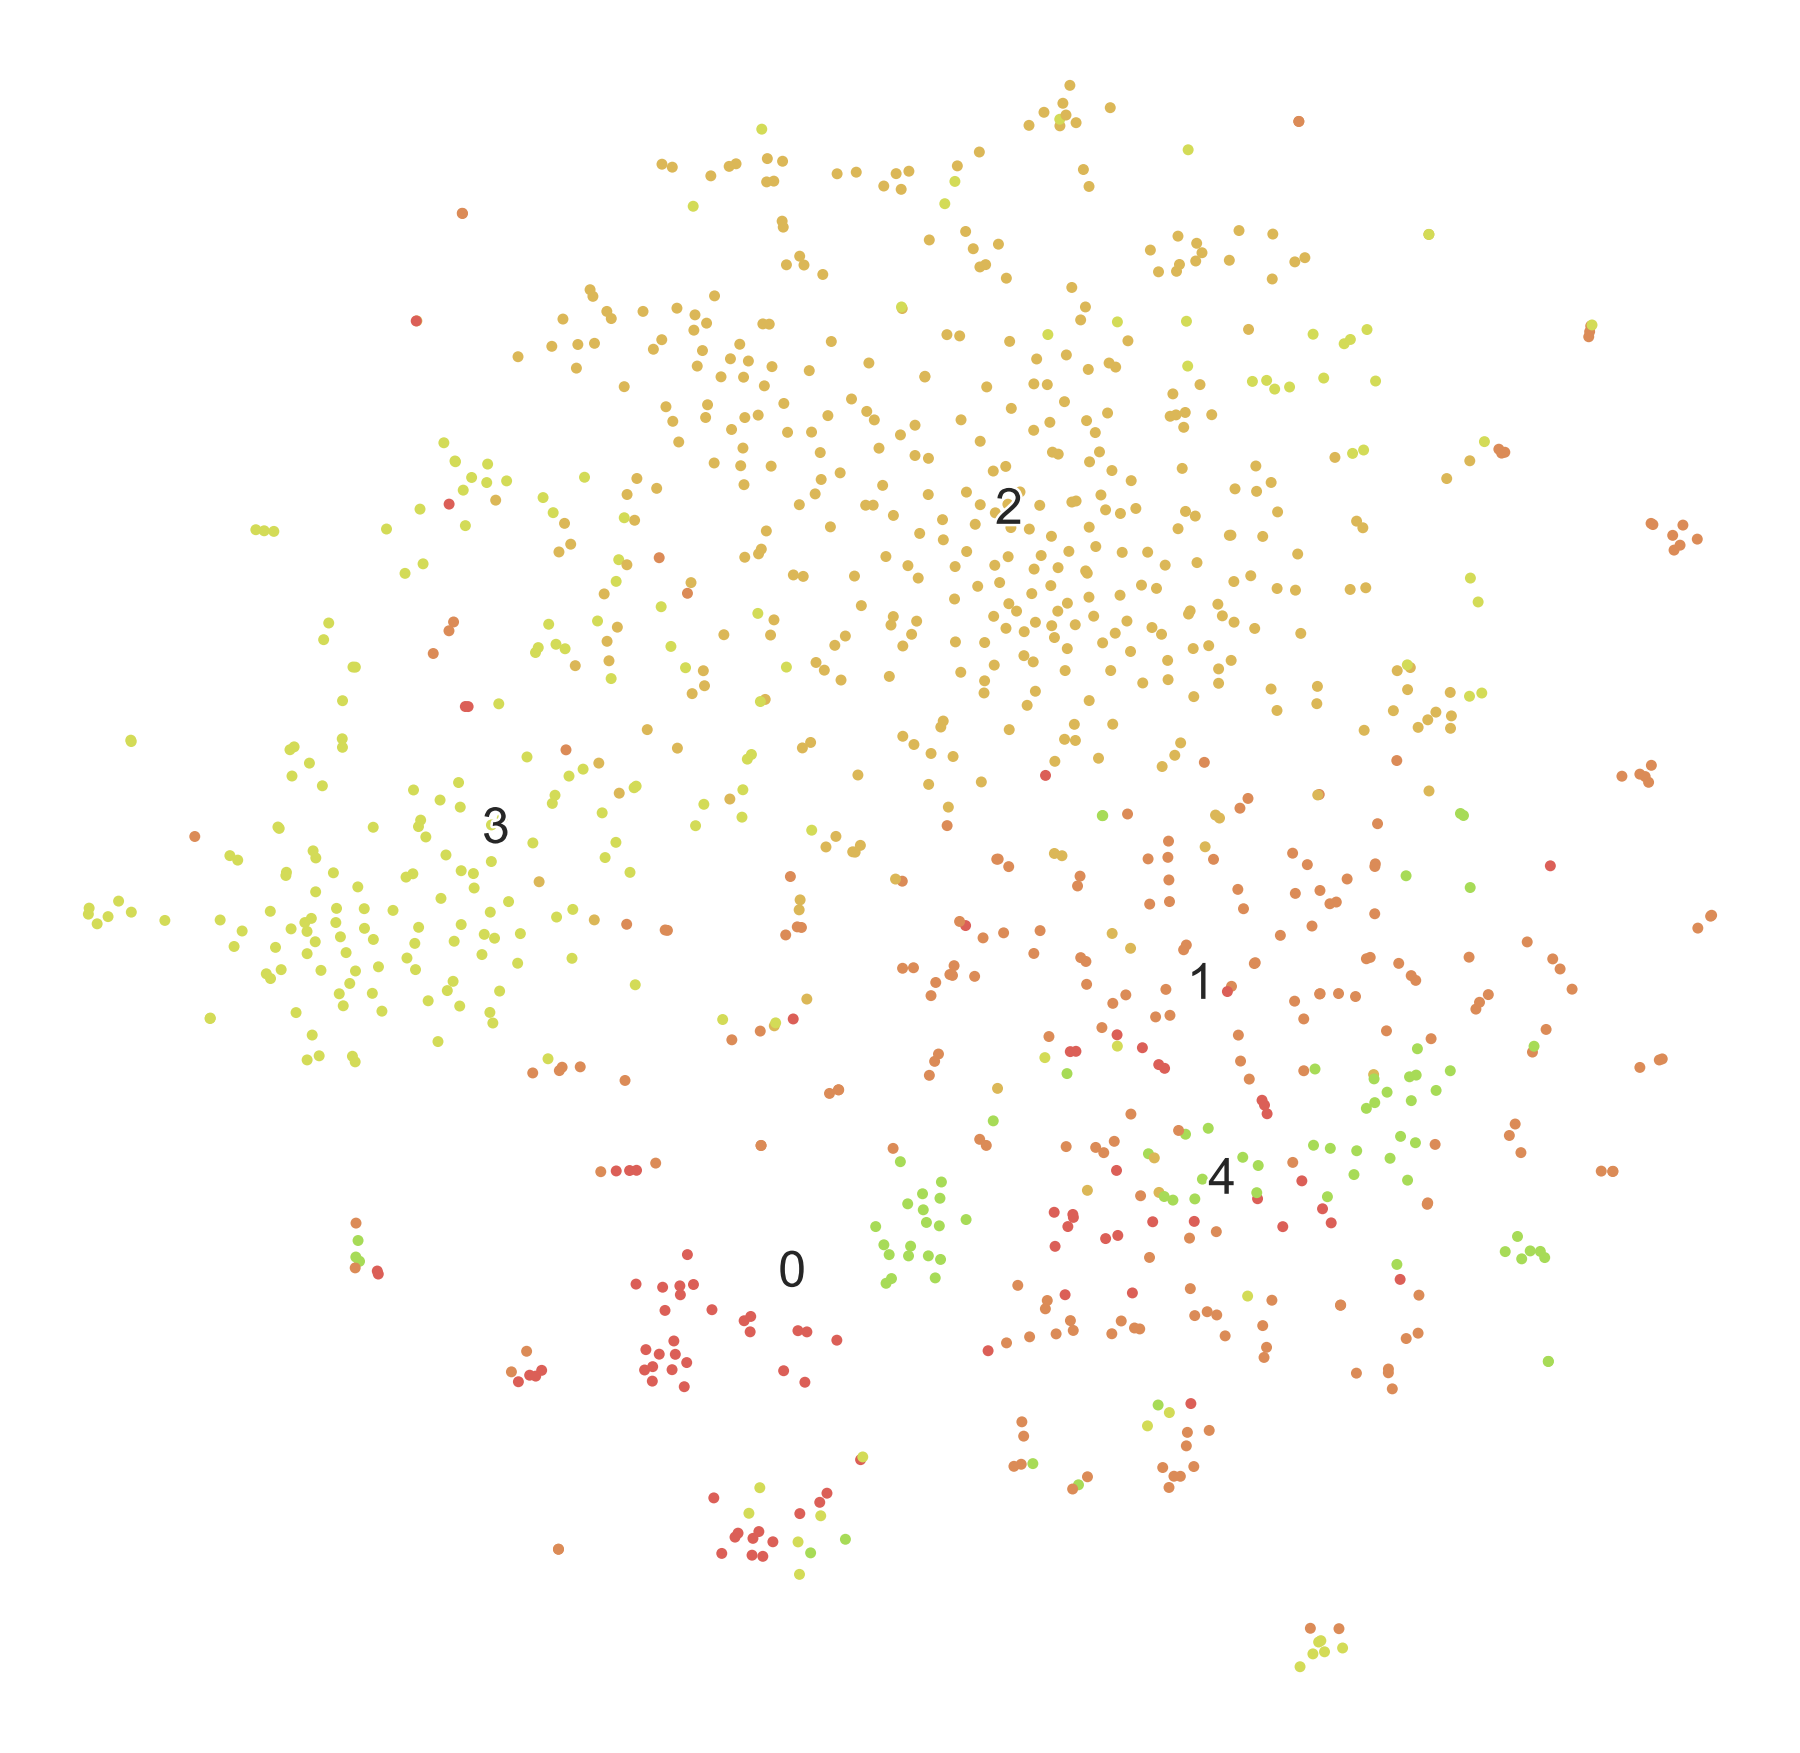

In [15]:
main()